## Blahut-Arimoto Algorithm

Iterative algorithm, iteretively computes the channel Capacity and the distortion Function. 
Clustering is a compression problem. We want to find the max compression given a desired distortion rate.

In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
import random as ran
import math as math

In [2]:
def read_and_convert_data_points(filename):
    """
    read_and_convert_data_points is a function that takes  a text file as an argument
    and converts it into an array containing all the datapoints.
    =============================================================================================
    :param filename: text file name in directory.
    :return: Npts x 2 array. 
    =============================================================================================
    """
    splits = []
    with open(filename, 'r') as f:
        data_points = f.readlines()
    
    for data_point in data_points:
        splits.append(data_point.split())
    
    return np.array(splits, dtype=np.float)

In [3]:
def scatter_plot(data, output_file_name='none',i=0):
    """
    scatter_plot is a function that plots the data and differenciate up to two clusters.
    =============================================================================================
    :param data: Npts x 2, data set array.
    :param output_file_name: 
    :i: idx of the first datapoint of the second cluster. 
    :return:
    =============================================================================================
    """
    if i != 0:
        x_1, y_1 = data[0:i].T
        x_2, y_2 = data[i:data.shape[0]].T
        plt.scatter(x_1, y_1, color='r')
        plt.scatter(x_2, y_2, color = 'g')
        
        if output_file_name =='none': 
            plt.show()
        else:
            plt.savefig(output_file_name)
            plt.show() 
    else:
        x, y = data.T
        plt.scatter(x,y)
        if output_file_name =='none': 
            plt.show()
        else:
            plt.savefig(output_file_name)
            plt.show()    


In [4]:
def initial_clustering_membership_probability(clusters_number):
    """
    initial_clustering_membership_probability is a function that takes as an argument the 
    number of clusters 'C' and generates a randon cluster membership probability per element 'i' 
    in the dataset composed by 'N'elements.
    The sum of an element cluster membership probabilities is be 1.
    =============================================================================================
    :param clusters_number: 'C'
    :return initial_cond_prob: C x N matrix. 
    =============================================================================================
    """ 
    initial_cond_prob = np.zeros((Npts,clusters_number))
    for i in range(Npts):
        x = np.random.rand(clusters_number)
        initial_cond_prob[i] = x/np.sum(x)
    return initial_cond_prob.transpose()

## Algorithm implementation:

In [5]:
def blahut_algorithm_imp(clusters_number,
                              priors,
                              distance_matrix,
                              beta, 
                              rounds=20,
                              threshold=1e-10
                             ):
    """
    the blahut_algorithm_imp function implements the Blahut Arimoto Algorithm for a given number 
    of clusters and a given value of beta.
    For each round it will:
    *firstly initialize the clustering membership probabilities randomly,
    *compute the evidence for each cluster 'C'(returns a vector), 
    *Compute the posterior probability per cluster: returns a matrix C x Npts
    *Compute the element to cluster distance: returns a matrix Npts x C
    After performing all the previous operations for all clusters 'C' the normalization (partition)
    function is created and posteriori to this the clustering membership probabilities are updated.
    The function will later try to minimize the Lagrange multiplier function until convergence 
    i.e, there is no improvement or the improvement is less than the threshold. When the function
    reaches this condition it gets out of the loop and starts the next round.
    
    =============================================================================================
    :param clusters_number: 
    :priors: prior probability for each data point, if uniformly distributed = 1/Npts
    :distance_matrix: Matrix containing the distance from every vector in x to every vector in y.
    :beta: distortion tradeoff parameter
    :rounds: number on rounds (iterations) perform for averaging results.
    :threshold: if the minimization of the lagrange multiplier result compared 
    to the previous iteration's result is less than the threshold the round will exit the loop.
    :returns: scalar value, mean of the expected distortion for each round.
    =============================================================================================
    """

    priors_matrix = np.full((Npts, 1), 1/float(Npts))
    D_results=[]
     
    for round in range(rounds): 
        D = []
        lagrange_multiplier=[]
        diff_elem_value=1
        membership_prob = initial_clustering_membership_probability(clusters_number)
        evidence_vector = np.zeros((clusters_number,))
        posteriori_prob = np.zeros((Npts, clusters_number)).transpose()
        element_cluster_distance_matrix = np.zeros((Npts, clusters_number))
        normalization_partition_funct = np.zeros((Npts, ))

        while (diff_elem_value > threshold):
  
            for c in range(clusters_number):

            #     Computes the evidence for each cluster 'C': returns a vector   
                evidence_vector[c] = np.sum(np.dot(membership_prob[c], priors))
            #     Computes the posterior probability: returns a matrix C x Npts
                posteriori_prob[c] = (np.dot(priors, membership_prob[c]))/evidence_vector[c]    

            #     Compute element to cluster distance:
                element_cluster_distance_matrix.transpose()[c] =(
                                                                np.multiply(
                                                                    posteriori_prob[c], distance_matrix_
                                                                           )
                                                                ).sum(axis=1,dtype='float')
            #compute partition function:
            exponential_beta_matrix = np.exp(-beta * element_cluster_distance_matrix)
            normalization_partition_funct = (np.multiply(evidence_vector, exponential_beta_matrix)).sum(axis=1)

            #update conditionnal cluster_proba
            membership_prob = (np.multiply
                                (evidence_vector, 
                                 exponential_beta_matrix)/ normalization_partition_funct[:,None]
                               ).transpose()

            #Compute averaged element to cluster distance:
            joint_probability = np.multiply(evidence_vector, posteriori_prob.transpose())
            d =np.sum(np.multiply(joint_probability,element_cluster_distance_matrix))

            D.append(d)
            ##Compute Compression rate:       
            ratios = posteriori_prob.transpose()/priors
            compression_rate_ = np.sum(np.multiply(joint_probability, np.log2(ratios)))

            ##Compute Lagrange Multiplier:
            lagrange_multiplier_ = compression_rate_ + beta*d
            lagrange_multiplier.append(lagrange_multiplier_)     

            if len(lagrange_multiplier) > 1:
                diff_elem_value = lagrange_multiplier[-2]-lagrange_multiplier[-1]

        D_results.append(D[-1])
        mean_D_results = sum(D_results)/float(rounds)
    return mean_D_results


In [6]:
def batch_perform_algorithm(range_betas_, prior_, distance_matrix, range_clusters=range(2, 5)):
    """
    batch_perform_algorithm will recursively call the blahut_algorithm_imp fuction for a number of
    clusters and distortion trade-off values (beta) it will return the coordenates of the value that
    minimizes the expected distortion for a given distortion trade-off. 
    =============================================================================================
    :param range_betas_:range of betas = list of the given betas (distortion trade-off values) 
    that want to be evaluated.
    :param prior_: prior probability for each data point, if uniformly distributed = 1/Npts
    :param distance_matrix: Matrix containing the distance from every vector in x to every vector in y.
    :range_clusters: range of clusters = list of the given range.
    =============================================================================================
    """
    results = np.zeros((len(range_clusters),len(range_betas_)))
    betas=np.zeros((len(range_betas_)))   
    coordenates = np.zeros((len(range_clusters), len(range_betas_),2))
    
    for idx, cluster_n in enumerate(range_clusters):
        for idx_beta, beta in enumerate(range_betas_):
            results[idx, idx_beta] = blahut_algorithm_imp(cluster_n,prior,distance_matrix,beta)
            betas[idx_beta]=beta
    
    for idx, cluster in enumerate(range_clusters):
        coordenates[idx].transpose()[0] = (-results[idx])
        coordenates[idx].transpose()[1] = betas

    return coordenates 

In [7]:
def plot_batch_information_curve(coordenates_, range_clusters=range(2, 5), out_filename='none'):
    """
    plot_batch_information_curve generates a plot with the given coordenates, where the x axis is
    the value of the distortion trade-off parameter and the y axis the (negative) expected distortion.
    =============================================================================================
    :param coordenates_: output of batch_perform_algorithm function, (C, Beta, 2) array.
    :param range_clusters: range of clusters = list of the given range
    :return: information curves plot
    =============================================================================================
    """
    colors = [
        '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c',
        '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080', '#ffffff', '#000000']
    plt.figure(figsize=(15,6))
    plt.style.use('seaborn-darkgrid')
    for i_coord, i_cluster in zip(range(coordenates_.shape[0]), range_clusters):
        y,x = coordenates_[i_coord].T
        plt.plot(x, y, marker='o', linestyle='--', color=colors[i_coord], label= f'Nc:{i_cluster}')    
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'$<-D>$')
    plt.legend(loc='best')
    if out_filename=='none':
        plt.show()
    else:
        plt.savefig(out_filename)
        plt.show() 

In [8]:
data_points = read_and_convert_data_points('Data_Exercise4_2019')

Without knowing the data, by sight we can say there're two clusters

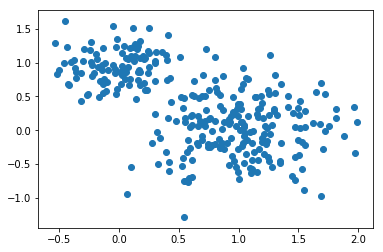

In [9]:
scatter_plot(data_points, 'scatter_plot.png')

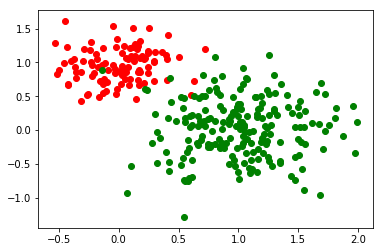

In [10]:
scatter_plot(data_points, output_file_name='scatter_plot_color.png', i=100)

In [11]:
Npts, Ndim = data_points.shape
prior = 1/float(Npts)
distance_matrix_= distance_matrix(data_points,data_points) # define similarities
range_clusters= range(2,5)

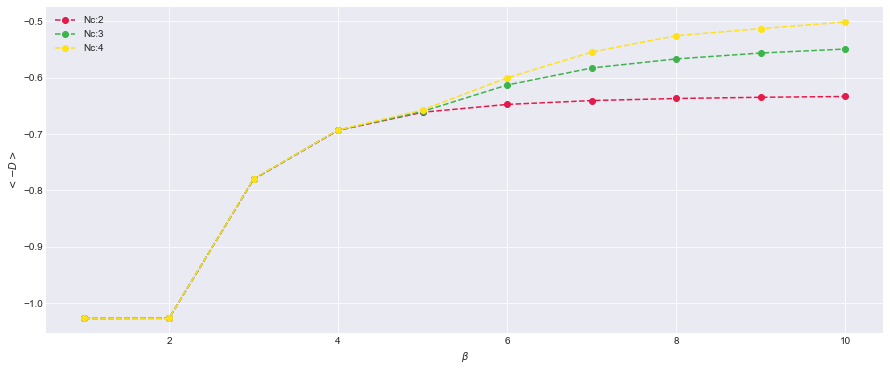

In [12]:
coordenates_beta_range_10 = batch_perform_algorithm(range(1,11), prior, distance_matrix_)
plot_batch_information_curve(coordenates_beta_range_10, range_clusters, out_filename='beta_range_10.png')

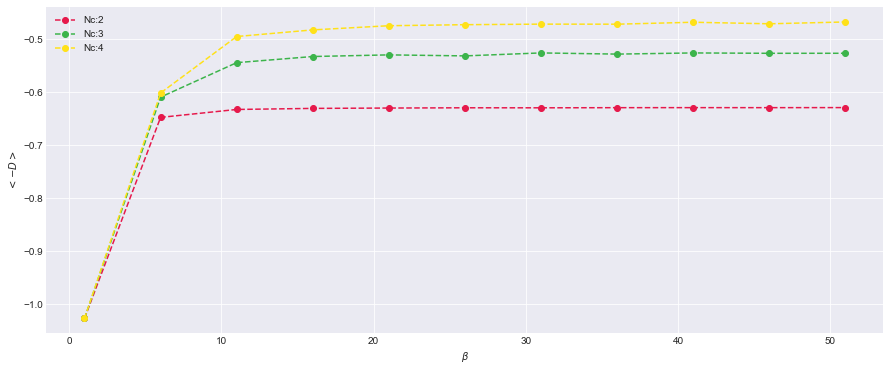

In [13]:
coordenates_beta_range_50 = batch_perform_algorithm(range(1,55,5), prior, distance_matrix_)
plot_batch_information_curve(coordenates_beta_range_50, range_clusters, out_filename='beta_range_50.png')